In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# unscaled, log-normalized counts, with conditions subsampled to the same number of cells 
# and 2000 highly variable genes calculated jointly across all perturbation conditions, including control, using scanpy28 with default parameters (Supplementary Methods)

In [3]:
from anndata import read_h5ad
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd 
import scanpy as sc
import seaborn as sns
import string
import sys
from sklearn.linear_model import LinearRegression
sys.path.append("../../scxmatch/src/")
from scxmatch import *
np.random.seed(42)

In [4]:
reference = 0
group_by = "dose_value"

In [5]:
ram = pd.read_csv("../evaluation_results/job_memory_usage.csv")
ram.loc[ram["k"] == 0, "k"] = ram.loc[ram["k"] == 0, "n_obs"] 
ram = ram.astype(float)

In [6]:
assert not ram.set_index(["k", "n_obs", "n_var"]).index.has_duplicates

In [7]:
df = pd.concat([pd.read_csv(f"../evaluation_results/runtime_memory_log_{n_obs}.txt", delimiter=",") for n_obs in [500, 1000, 2000, 5000, 10000, 20000, 50000]])

In [8]:
df_filtered = df[~(df.eq(df.columns).all(axis=1))]
df_filtered.loc[df_filtered["k"].isna(), "k"] = df_filtered.loc[df_filtered["k"].isna(), "n_obs"] 
df_filtered = df_filtered.astype(float)

In [9]:
assert not df_filtered.set_index(["k", "n_obs", "n_var"]).index.has_duplicates

In [10]:
conc = pd.concat([ram.set_index(["k", "n_obs", "n_var"]), df_filtered.set_index(["k", "n_obs", "n_var"])], axis=1).reset_index()

In [11]:
assert len(conc[conc.isna().any(axis=1)].sort_values(["n_obs", "k"])[["k", "n_obs", "n_var"]].sort_values(["k", "n_obs", "n_var"])) == 0

In [12]:
conc["upper_lim_edges"] = conc["k"] * conc["n_obs"]

In [13]:
conc["t_total"] = conc["t_NN [s]"] + conc["t_matching [s]"]

In [14]:
conc.rename({"n_obs": "$n_{obs}$", "n_var": "$n_{var}$", "k": "$k$"}, axis=1, inplace=True)

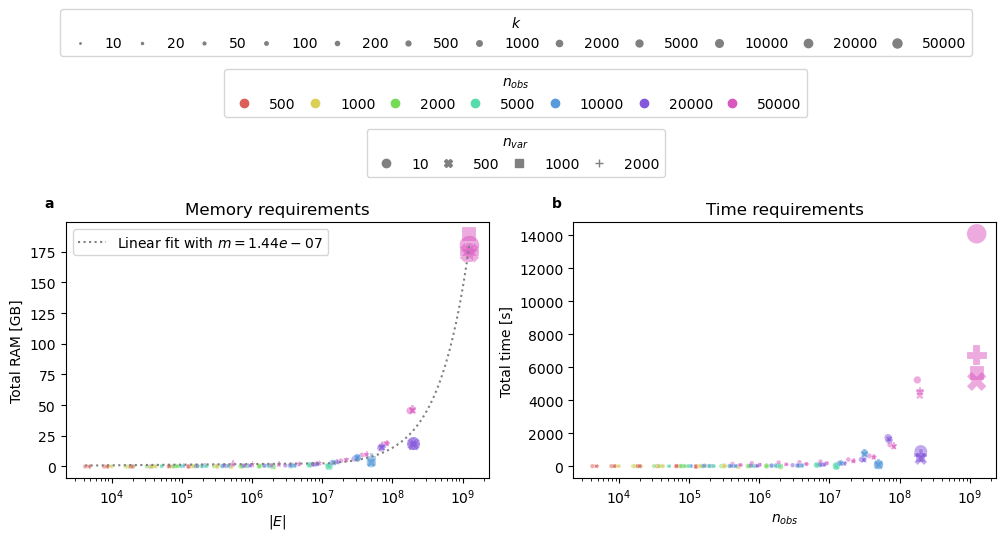

In [36]:
f, axs = plt.subplots(1, 2, figsize=(12, 4))
#f.set_size_inches(12, 8)  
plt.subplots_adjust(top=0.75)

X = conc.loc[(conc["$k$"] > 0) & (conc["n_edges"].notna()), "n_edges"].values.reshape(-1, 1)
y = conc.loc[(conc["$k$"] > 0) & (conc["n_edges"].notna()), "total_ram_gb"].values.reshape(-1, 1)
lr = LinearRegression().fit(X, y)

conc[["$k$", "$n_{obs}$", "$n_{var}$"]] = conc[["$k$", "$n_{obs}$", "$n_{var}$"]].astype(int)
sns.scatterplot(conc.loc[conc["$k$"] > 0], ax=axs[0], x="n_edges", y="total_ram_gb", hue="$n_{obs}$", size="$k$", sizes=(10, 200), style="$n_{var}$", palette=sns.color_palette("hls", 7), alpha=0.5, legend=False)

X_fit = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
y_fit = lr.predict(X_fit)
axs[0].plot(X_fit, y_fit, color="grey", label=f"Linear fit with $m={lr.coef_.item():.2e}$", ls="dotted")
axs[0].legend()
axs[0].set_ylabel("Total RAM [GB]")
axs[0].set_xlabel("$|E|$")
axs[0].set_xscale("log")
axs[0].set_title("Memory requirements")

sns.scatterplot(conc.loc[conc["$k$"] > 0], ax=axs[1], x="n_edges", y="t_total", hue="$n_{obs}$", size="$k$", sizes=(10, 200), style="$n_{var}$", palette=sns.color_palette("hls", 7), alpha=0.5, legend=False)


handles_size = [plt.Line2D([], [], marker='o', color="grey", linestyle='None', markersize=1 + i / 2, label=s)
                for i, s in enumerate(sorted(conc["$k$"].unique()))]

handles_color = [plt.Line2D([], [], marker='o', linestyle='None', color=sns.color_palette("hls", 7)[i], label=c)
                 for i, c in enumerate(sorted(conc["$n_{obs}$"].unique()))]


handles_marker = [plt.Line2D([], [], marker=m, color="grey", linestyle='None', label=sorted(conc["$n_{var}$"].unique())[i])
                  for i, m in enumerate(["o", "X", "s", "+"])]
axs[1].set_xscale("log")
axs[1].set_ylabel("Total time [s]")
axs[1].set_xlabel("$n_{obs}$")
axs[1].set_title("Time requirements")

f.legend(handles=handles_size, title="$k$", loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=12, columnspacing=0.4)
f.legend(handles=handles_color, title="$n_{obs}$", loc='upper center', bbox_to_anchor=(0.5,1.15), ncol=7, columnspacing=0.4)
f.legend(handles=handles_marker, title="$n_{var}$", loc='upper center', bbox_to_anchor=(0.5, 1), ncol=4, columnspacing=0.4)

labels = ["a", "b"]
for i, label in enumerate(labels):
    axs[i].text(
        -0.05, 1.1,  # Position (normalized figure coordinates)
        labels[i],   # Corresponding letter
        transform=axs[i].transAxes,  # Relative to subplot
        fontsize=10, fontweight='bold', va='top', ha='left'
    )
#plt.tight_layout(rect=[0, 0, 0.85, 1])  
#plt.savefig("../plots/fig2/runtime_memory.pdf", bbox_inches="tight")

In [16]:
conc_full = conc[conc["$n_{obs}$"] == conc["$k$"]]
conc_k = conc[conc["$n_{obs}$"] != conc["$k$"]]

In [66]:
sizes = {k: 1 + (i**2) * 3 for i, k in enumerate(sorted(conc["$k$"].unique()))}
colors = {n_obs: sns.color_palette("hls", 7)[i] for i, n_obs in enumerate(sorted(conc["$n_{obs}$"].unique()))}

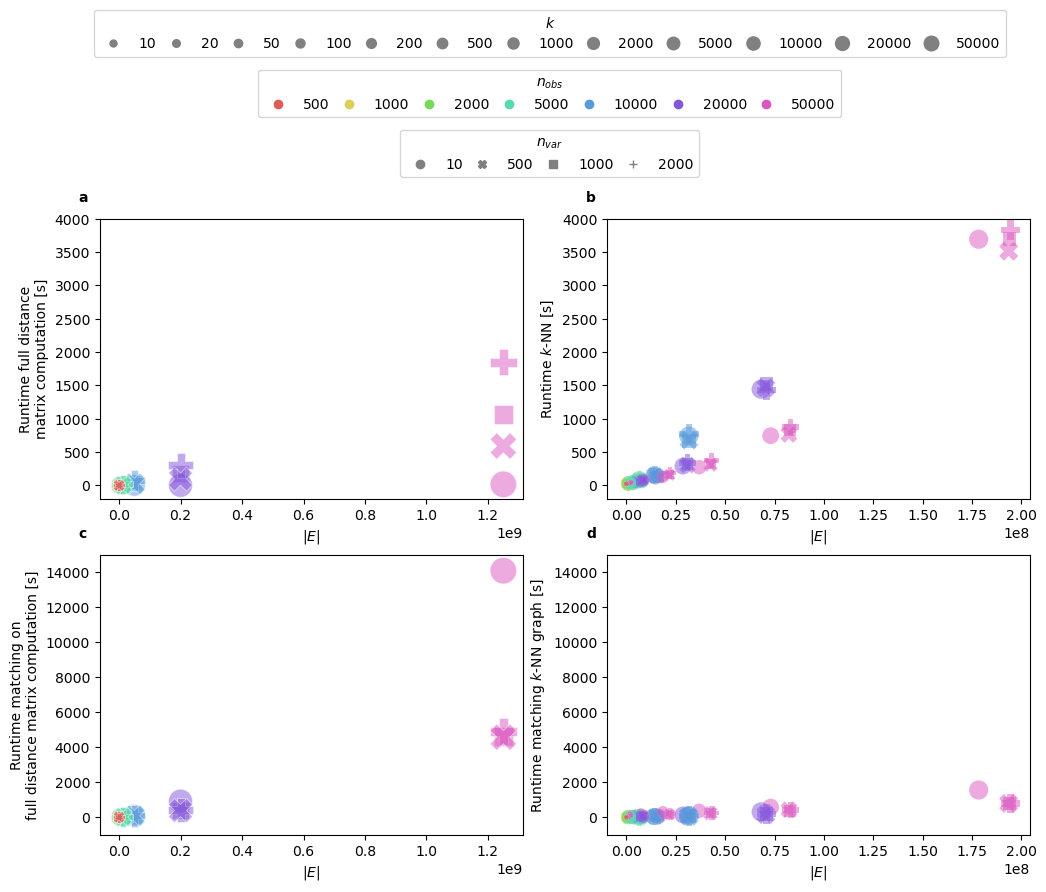

In [68]:
f, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=False)

sns.scatterplot(conc_full, ax=axs[0, 0], x="n_edges", y="t_NN [s]", hue="$n_{obs}$", size="$k$", sizes=sizes, style="$n_{var}$", palette=colors, alpha=0.5, legend=False)
sns.scatterplot(conc_k, ax=axs[0, 1], x="n_edges", y="t_NN [s]", hue="$n_{obs}$", size="$k$", sizes=sizes, style="$n_{var}$", palette=colors, alpha=0.5, legend=False)
sns.scatterplot(conc_full, ax=axs[1, 0], x="n_edges", y="t_matching [s]", hue="$n_{obs}$", size="$k$", sizes=sizes, style="$n_{var}$", palette=colors, alpha=0.5, legend=False)
sns.scatterplot(conc_k, ax=axs[1, 1], x="n_edges", y="t_matching [s]", hue="$n_{obs}$", size="$k$", sizes=sizes, style="$n_{var}$", palette=colors, alpha=0.5, legend=False)

axs[0, 0].set(ylim=(-200, 4000))
axs[0, 1].set(ylim=(-200, 4000))
axs[1, 0].set(ylim=(-1000, 15000))
axs[1, 1].set(ylim=(-1000, 15000))

axs[0, 0].set_ylabel("Runtime full distance\nmatrix computation [s]")
axs[0, 1].set_ylabel("Runtime $k$-NN [s]")
axs[1, 0].set_ylabel("Runtime matching on\nfull distance matrix computation [s]")
axs[1, 1].set_ylabel("Runtime matching $k$-NN graph [s]")
axs[0, 0].set_xlabel("$|E|$")
axs[0, 1].set_xlabel("$|E|$")
axs[1, 0].set_xlabel("$|E|$")
axs[1, 1].set_xlabel("$|E|$")


handles_size = [plt.Line2D([], [], marker='o', color="grey", linestyle='None', markersize=5 + i / 2, label=s)
                for i, s in enumerate(sorted(conc["$k$"].unique()))]
handles_color = [plt.Line2D([], [], marker='o', linestyle='None', color=sns.color_palette("hls", 7)[i], label=c)
                 for i, c in enumerate(sorted(conc["$n_{obs}$"].unique()))]
handles_marker = [plt.Line2D([], [], marker=m, color="grey", linestyle='None', label=sorted(conc["$n_{var}$"].unique())[i])
                  for i, m in enumerate(["o", "X", "s", "+"])]


f.legend(handles=handles_size, title="$k$", loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=12, columnspacing=0.4)
f.legend(handles=handles_color, title="$n_{obs}$", loc='upper center', bbox_to_anchor=(0.5,1.075), ncol=7, columnspacing=0.4)
f.legend(handles=handles_marker, title="$n_{var}$", loc='upper center', bbox_to_anchor=(0.5, 1), ncol=4, columnspacing=0.4)

labels = ["a", "b", "c", "d"]

for i, label in enumerate(labels):
    axs[i // 2, i % 2].text(
        -0.05, 1.1,  # Position (normalized figure coordinates)
        labels[i],   # Corresponding letter
        transform=axs[i // 2, i % 2].transAxes,  # Relative to subplot
        fontsize=10, fontweight='bold', va='top', ha='left'
    )

plt.savefig("../plots/supplementary/supp_runtime_memory.pdf", bbox_inches="tight")